# Course 4 - Project - Part 8: Convolutional neural network

<a name="top-8"></a>
This notebook is concerned with *Part 8: Convolutional neural network*.

**Contents:**
* [Step 0: Loading data](#step-8.0)
* [Step 1: Convolutional neural network](#step-8.1)

## Step 0: Loading data<a name="step-7.0"></a> ([top](#top-7))
---

We load the training set with the extracted high-level features.

In [1]:
# Standard library.
import os
import pathlib
import typing as T

# 3rd party.
import numpy as np

# Project.
import utils

In [2]:
separator = ''.center(80, '-')

path_train = pathlib.Path.cwd() / 'data' / 'swissroads-features-train.npz'
data_train = utils.load(path_train)
print(separator)
print(f'Dataset: train\n{utils.info(data_train)}')

path_valid = pathlib.Path.cwd() / 'data' / 'swissroads-features-valid.npz'
data_valid = utils.load(path_valid)
print(separator)
print(f'Dataset: valid\n{utils.info(data_valid)}')

path_test = pathlib.Path.cwd() / 'data' / 'swissroads-features-test.npz'
data_test = utils.load(path_test)
print(separator)
print(f'Dataset: test\n{utils.info(data_test)}')

--------------------------------------------------------------------------------
Dataset: train
data: shape=(280, 224, 224, 3), dtype=float32
label_idxs: shape=(280,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(280,), dtype=<U19
features: shape=(280, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: valid
data: shape=(139, 224, 224, 3), dtype=float32
label_idxs: shape=(139,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(139,), dtype=<U19
features: shape=(139, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: test
data: shape=(50, 224, 224, 3), dtype=float32
label_idxs: shape=(50,), dtype=int64
label_strs: shape=(6,), dtype=<U10
names: shape=(50,), dtype=<U19
features: shape=(50, 1280), dtype=float32


In [3]:
label_strs = data_train['label_strs']  # Same for all data sets.
assert (
    np.all(data_train['label_strs'] == data_valid['label_strs']) and
    np.all(data_train['label_strs'] == data_test['label_strs'])
)

X_train = data_train['data']
y_train = data_train['label_idxs']
F_train = data_train['features']
N_train = data_train['names']

X_valid = data_valid['data']
y_valid = data_valid['label_idxs']
F_valid = data_valid['features']
N_valid = data_train['names']

X_test = data_test['data']
y_test = data_test['label_idxs']
F_test = data_test['features']
N_test = data_test['names']

We fix the seed for the PRNG in order to make computations deterministic.

In [4]:
RANDOM_SEED = 0

## Step 1: Convolutional neural network<a name="step-8.1"></a> ([top](#top-8))
---

In [5]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import ParameterGrid
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

We build the model from Subject 08 - Unit 06.

In [73]:
def build_model(dropout_rate: float = 0.5,
                l2_alpha: float=0.01):
    """\
    Builds, compiles and returns a Keras model.

    .. seealso:: https://keras.io/scikit-learn-api/
    """    
    # Create model.
    model = keras.Sequential()

    # Input layer with 256 x 256 RGB images.
    model.add(layers.InputLayer(input_shape=(256, 256, 3)))
    
    #
    # 2 Convolutional/max-pooling layers.
    #
              
    # Convolutional layer - 64 filters, kernel: 5 x 5, stride: 2 x 2, padding: "same", activation: ReLU.
    model.add(layers.Conv2D(filters=64, kernel_size=10, strides=5, padding='same', activation='relu'))

    # Maxpool layer - pool-size: 2 x 2, strides: 2 x 2, padding: "same".
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
              
    # Convolutional layer - 64 filters, kernel: 3 x 3, stride: 1 x 1, padding: "same", activation: ReLU.
    model.add(layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
    
    # Maxpool layer - pool-size: 2 x 2, stride: 2 x 2, padding: "same".
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))

    #
    # Dropout, 2 fully connected layers.
    #
    
    model.add(layers.Flatten())     
    model.add(layers.Dropout(dropout_rate, seed=RANDOM_SEED))

    model.add(layers.Dense(
        units=512, activation='relu',
        kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=RANDOM_SEED),
        kernel_regularizer=keras.regularizers.l2(l=l2_alpha)))

    # Output layer.
    model.add(layers.Dense(
        units=6, activation='softmax',
        kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=RANDOM_SEED),
        kernel_regularizer=keras.regularizers.l2(l=l2_alpha)))

    # Compile the model.
    model.compile(
        optimizer=optimizers.Adam(),  # use defaults
        loss=losses.categorical_crossentropy,
        metrics=['acc']
    )

    return model

In [74]:
model = build_model()

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 52, 52, 128)       38528     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 26, 26, 128)       409728    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 21632)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               11076096  
__________

In [76]:
# Standard library.
import pathlib

# 3rd party.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We apply the following data augmentation.

In [77]:
# Create image generator
train_generator = ImageDataGenerator(
    rescale=1/255, 
    # Augmentations:
    rotation_range=10,  # ±10 degrees
    width_shift_range=0.1,  # ±10%
    height_shift_range=0.1,  # ±10%
    brightness_range=(0.8, 1.2),  # 80% (darker) to 120% (brighter)
    zoom_range=(0.8, 1.2),  # 80% (zoom in) to 120% (zoom out)
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.0
)

# Training, validation and test sets.
base_path = pathlib.Path.cwd() / 'data' / 'swissroads'
assert base_path.is_dir()

train_set = train_generator.flow_from_directory(
    base_path / 'train', batch_size=32, target_size=(256, 256), shuffle=True, seed=RANDOM_SEED)
valid_set = train_generator.flow_from_directory(
    base_path / 'valid', batch_size=32, target_size=(256, 256), shuffle=False)
test_set = test_generator.flow_from_directory(
    base_path / 'test', batch_size=32, target_size=(256, 256), shuffle=False)

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [78]:
train_set.num_classes

6

In [79]:
train_set.class_indices

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

In [80]:
# Trick: end training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train model
history = model.fit_generator(
    generator=train_set, validation_data=valid_set, epochs=100, callbacks=[early_stopping])

Epoch 1/100
9/9 [==============================] - 11s 1s/step - loss: 8.6759 - acc: 0.2061 - val_loss: 5.1802 - val_acc: 0.2302
Epoch 2/100
9/9 [==============================] - 8s 907ms/step - loss: 3.9014 - acc: 0.2382 - val_loss: 2.9301 - val_acc: 0.2230
Epoch 3/100
9/9 [==============================] - 8s 904ms/step - loss: 2.6236 - acc: 0.2469 - val_loss: 2.3433 - val_acc: 0.2374
Epoch 4/100
9/9 [==============================] - 8s 896ms/step - loss: 2.2247 - acc: 0.2479 - val_loss: 2.0794 - val_acc: 0.3309
Epoch 5/100
9/9 [==============================] - 8s 894ms/step - loss: 2.0016 - acc: 0.3465 - val_loss: 1.8782 - val_acc: 0.3165
Epoch 6/100
9/9 [==============================] - 8s 902ms/step - loss: 1.8374 - acc: 0.3719 - val_loss: 1.7499 - val_acc: 0.4029
Epoch 7/100
9/9 [==============================] - 8s 908ms/step - loss: 1.7538 - acc: 0.3750 - val_loss: 1.7764 - val_acc: 0.3165
Epoch 8/100
9/9 [==============================] - 8s 921ms/step - loss: 1.7292 - acc

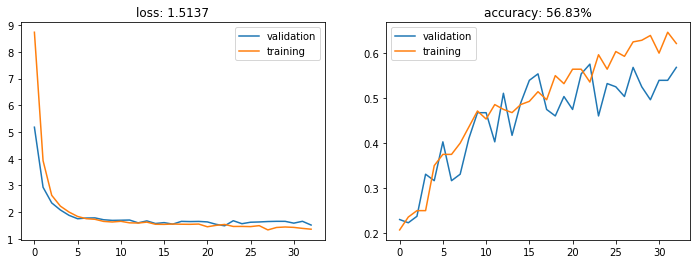

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
ax1.plot(history.history['val_loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
ax2.plot(history.history['val_acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()